# Neural Network Training

In [212]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class Layer :
    def __init__(self,weight,bias) :
        self.weight = weight
        self.bias =  bias
        
    def activationSigmoid(self,input) : #Sigmoid
        sigmoid = torch.sigmoid(input)
        return sigmoid
    
    def activationRelu(self,input) : #ReLu
        m = nn.ReLU()
        return m(input)
    
    def activationSM(self,input) : #SoftMax
        #A = torch.exp(input) / torch.sum(torch.exp(input))
        #return A
        m = nn.Softmax(dim=1)
        return m(input)
        
    def forward1(self, input) :
        output=(torch.matmul(input.double(),self.weight.double()))+self.bias
        return output,self.activationRelu(output).double()
    
    
    def forward2(self, input) :
        output=(torch.matmul(input.double(),self.weight.double()))+self.bias
        return output,self.activationSM(output).double()
        
    
       
class Network:
    def __init__(self,w1,b1,w2,b2, batch_size = 10):
        self.batch_size = batch_size
        # network
        self.layer1 = Layer(w1,b1)
        self.layer2 = Layer(w2,b2)

    def forward1(self, x):
        pred,a = self.layer1.forward1(x)
        return pred,a
    
    def forward2(self, x):
        pred,y = self.layer2.forward2(x)
        return pred,y

    
    def single_processing(self, input, target) :
            pred1,error1 = self.forward1(input)
            pred2,error2 = self.forward2(error1)
            return pred1,error1,pred2,error2
            
    
    def evaluate(self, pred, target) : #L1
        loss = nn.L1Loss()
        output = loss(pred,target)
        return output        
                
    #Create batch, then process each batch
    def batch_processing(self, input, target) :
        for i in range(0,len(input)-1,2):
            new_len=[input[i].tolist(),input[i+1].tolist()]
            new_ten=torch.Tensor(new_len)
            new_tar=[target[i].tolist(),target[i+1].tolist()]
            new_tar2=torch.Tensor(new_tar)
            self.single_processing(new_ten,new_tar2)

# Load Data

In [65]:
trainset= MNIST('dataset_mnist',True, download= True)
trainset= MNIST('dataset_mnist',False, download= True)

In [66]:
trainset.data.shape

torch.Size([10000, 28, 28])

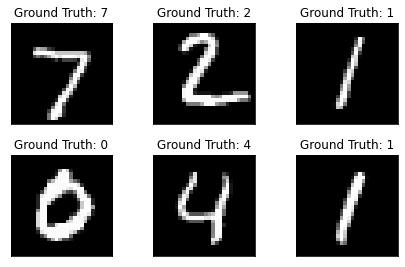

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trainset[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(trainset.targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [68]:

print(trainset.targets)

tensor([7, 2, 1,  ..., 4, 5, 6])


# Modeling Data

In [223]:
x_trains=trainset.data
y_trains=trainset.targets

#modeling
x_train=x_trains.reshape(-1,28*28)
x_train=x_train.float()
x_train=x_train/255
x_testing=x_train
y_testing=y_trains

#train
x_train=x_train[:8000]
y_train=y_train[:8000]
print(x_train.shape)

#testing
x_testing=x_testing[8000:]
y_testing=y_testing[8000:]
print(x_testing.shape)

torch.Size([8000, 784])
torch.Size([2000, 784])


# Call Neural Network Training Class

In [228]:
seed=52
learning_rate=0.01

m, n = x_train.shape
print (m,n)

                
def Y_res(Y):
    Y_res = np.zeros((list(y_train.shape)[0], 10))
    Y_res[np.arange(list(y_train.shape)[0]), Y] = 1
    #one_hot_Y = one_hot_Y.T
    return Y_res.astype(float)
   
def ReLU_deriv(Z):
    return (Z > 0) * 1
    
    
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
        Z1=Z1.numpy()
        Z2=Z2.numpy()
        A1=A1.numpy()
        A2=A2.numpy()
        W2=W2.numpy()
        W1=W1.numpy()
        Y_result = Y_res(Y)
        dZ2 = A2 - Y_result
        dW2 = 1 / m * dZ2.T.dot(A1)
        db2 = 1 / m * np.sum(dZ2)
        
        dZ1 = W2.T.dot(dZ2.T) * ReLU_deriv(Z1).T
        dW1 = 1 / m * dZ1.dot(X)
        db1 = 1 / m * np.sum(dZ1)

        return torch.tensor(dW1), torch.tensor(db1), torch.tensor(dW2), torch.tensor(db2)
        
def get_predictions(A2):
    return torch.argmax(A2, 0)

def get_accuracy(predictions, Y):
    acc=0
    print(predictions.size())
    for i in range (m):
        if predictions[i]==Y[i]:
            acc=acc+1
            #print("sama",predictions[i],Y[i])
    #return torch.sum(predictions == Y) / m
    return acc / m
    
def forward_prop(w1, b1, w2, b2 , X):
    model = Network(w1,b1,w2,b2)
    pred1,error1,pred2,error2=model.single_processing(x_train,y_train)
    return pred1.double(), error1.double(), pred2.double(), error2.double()
        
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - (alpha * dW1).T
    b1 = b1 - alpha * db1
    W2 = W2 - (alpha * dW2).T  
    b2 = b2 - alpha * db2
    return torch.tensor(W1), torch.tensor(b1),torch.tensor(W2), torch.tensor(b2)

def init_params():
    torch.manual_seed(52)
    w1 = torch.randn((784,10))
    b1 =  torch.randn((10))
    #layer2
    w2 = torch.randn((10,10))
    b2 =  torch.randn((10))
    return w1,b1,w2,b2

def weight_decay(X):
    return X


       
def gradient_descent(X, Y, alpha, iterations,stop):
    w1, b1, w2, b2 = init_params()
    fatal=0
    E1=0 
    for i in range(iterations):
        #print("awal: ",w2)
        Z1, A1, Z2, A2 = forward_prop(w1,b1,w2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y)
        w1,b1,w2, b2 = update_params(w1,b1,w2, b2, dW1, db1, dW2, db2,alpha)
        #print("Akhir: ",w2)
        if(i%10==0):
            print("Iteration: ", i)
            predictions = get_predictions(A2.t())
            print("Predict: ", predictions, "Y:", Y)
            print(get_accuracy(predictions, Y))
            #######EARLY_STOP###############
            if(E1>get_accuracy(predictions, Y)):
                fatal=fatal+1
                E1=E1
                print(fatal)
            else:
                E1=get_accuracy(predictions, Y)
                fatal=0
            if(fatal==stop):
                    return w1,b1,w2, b2
                
            
    return w1,b1,w2, b2


W1, b1, W2, b2 = gradient_descent(x_train, y_train, 0.01, 10000,8)


8000 784
Iteration:  0
Predict:  tensor([6, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.06675
torch.Size([8000])
torch.Size([8000])


C:\Users\Intel\AppData\Local\Temp\ipykernel_11392\1103304487.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(W1), torch.tensor(b1),torch.tensor(W2), torch.tensor(b2)


Iteration:  10
Predict:  tensor([6, 1, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.073125
torch.Size([8000])
torch.Size([8000])
Iteration:  20
Predict:  tensor([6, 1, 3,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.0845
torch.Size([8000])
torch.Size([8000])
Iteration:  30
Predict:  tensor([6, 1, 3,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.103
torch.Size([8000])
torch.Size([8000])
Iteration:  40
Predict:  tensor([6, 1, 3,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.119875
torch.Size([8000])
torch.Size([8000])
Iteration:  50
Predict:  tensor([6, 1, 3,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.1315
torch.Size([8000])
torch.Size([8000])
Iteration:  60
Predict:  tensor([6, 1, 2,  ..., 3, 4, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.140625
torch.Size([8000])
torch.Size([8000])
Iteration:  70
Predict:  tensor([6, 1, 2,  ...,

Iteration:  530
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.392125
torch.Size([8000])
torch.Size([8000])
Iteration:  540
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.396125
torch.Size([8000])
torch.Size([8000])
Iteration:  550
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.4015
torch.Size([8000])
torch.Size([8000])
Iteration:  560
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.40575
torch.Size([8000])
torch.Size([8000])
Iteration:  570
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.409125
torch.Size([8000])
torch.Size([8000])
Iteration:  580
Predict:  tensor([7, 3, 2,  ..., 2, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.411875
torch.Size([8000])
torch.Size([8000])
Iteration:  590
Predict:  tensor([7, 

Iteration:  1060
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.459625
torch.Size([8000])
torch.Size([8000])
Iteration:  1070
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.45975
torch.Size([8000])
torch.Size([8000])
Iteration:  1080
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.459125
torch.Size([8000])
1
Iteration:  1090
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.459125
torch.Size([8000])
2
Iteration:  1100
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.459
torch.Size([8000])
3
Iteration:  1110
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.4585
torch.Size([8000])
4
Iteration:  1120
Predict:  tensor([7, 2, 2,  ..., 0, 7, 0]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.

# Validation

In [227]:
# print("W1",W1)
# print("b1",b1)
# print("W2",W2)
# print("b2",b2)
def make_predictions(index,X, W1, b1, W2, b2):
    Z1,A1,Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2[index])
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_testing[index, :, None]
    prediction = make_predictions(index,x_testing[index,:, None], W1, b1, W2, b2)
    label = y_testing[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Prediction:  tensor(7)
Label:  tensor(4)
Prediction:  tensor(2)
Label:  tensor(9)
Prediction:  tensor(2)
Label:  tensor(9)
Prediction:  tensor(0)
Label:  tensor(7)
